In [347]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import scanpy as sp

#distribution of distances between 2 types instead of just observation frequency

filepaths = ['/home/imaging_mfish/MERSCOPENAS04_data/human/atlas/merfish_output/202204251522_H1930002Cx58V10200710104_VMSC02501/processed/202204251522_H1930002Cx58V10200710104_VMSC02501.h5ad']
cell_h5ad = sp.read_h5ad(filepaths[0]) 
#obs has class, obsm spatial has location. IDs are matched (so spatial 0 = obs 0)
cell_data = cell_h5ad.obs
cell_data[['x', 'y']] = cell_h5ad.obsm['spatial']
test_data = cell_data.head()
test_data

,cluster,cross_species_cluster,subclass,neighborhood,class,merscope,avg.cor,genes_detected,total_reads,prob,volume,x,y
47962037932242942010876555014399066112,Oligo_1,Oligo_1,Oligo,glia,glia,VMSC02501,0.538810,31.0,116.0,0.92,1202.657606,1749.503892,8207.890195
104733048619761420241821555670701309952,Oligo_2,Oligo_1,Oligo,glia,glia,VMSC02501,0.602322,33.0,317.0,0.58,1135.954103,1841.328667,8252.400079
111938180339999722330573097470164729856,Oligo_1,Oligo_1,Oligo,glia,glia,VMSC02501,0.665623,26.0,189.0,1.00,1121.707984,1923.516669,8294.412081
114050102314760793254691965811466174464,Oligo_1,Oligo_1,Oligo,glia,glia,VMSC02501,0.583533,63.0,719.0,0.78,2054.240459,1979.730671,8271.840080
124807633030898724417537547466113548288,Oligo_4,Oligo_1,Oligo,glia,glia,VMSC02501,0.221800,47.0,78.0,0.21,670.039973,1937.772670,8364.342082


In [151]:
# real_data = cell_data.copy() #maybe not needed for the future, just doing this out of paranoia for now
# obs_freq_calculator(real_data).to_csv('real_grouped_obs_freq.csv')
#random 50um circle
theta = np.random.uniform(low=0, high=2*np.pi, size=1000)  # angle
rand_circle_points = pd.DataFrame({'x' : np.sqrt(50) * np.cos(theta), 'y' : np.sqrt(50) * np.sin(theta)})
#plot points above to make sure they're within circle and not on outside of circle
#make a uniform distribution of xy points in a square and remove points that are outside a circle, fine fn

# grouped_interactions = pd.DataFrame(columns=['count', 'root_cell_type', 'int_cell_type', 'obs_freq'])
# for rand_point in rand_circle_points:
#     # randomize spatial location of all cells within a radius of 50 μm and recalculate observed frequency 
#     data_copy = real_data.copy()
#     randomized_data = data_copy[['x_microns', 'y_microns']] * rand_point[['x', 'y']]
#     grouped_interactions.append(obs_freq_calculator(fake_dists_df))
# grouped_interactions.to_csv('fake_grouped_obs_freq_calcs.csv')

,x,y
0,2.262702,-6.699267
1,-6.911079,-1.495655
2,-7.058107,-0.427929
3,-3.324733,6.240685
4,4.560013,5.404284
...,...,...
995,3.996235,-5.833533
996,-7.057645,-0.435488
997,-7.058519,-0.421081
998,4.607645,-5.363731


,cluster,cross_species_cluster,subclass,neighborhood,class,merscope,avg.cor,genes_detected,total_reads,prob,volume,x,y
47962037932242942010876555014399066112,Oligo_1,Oligo_1,Oligo,glia,glia,VMSC02501,0.538810,31.0,116.0,0.92,1202.657606,1749.503892,8207.890195
104733048619761420241821555670701309952,Oligo_2,Oligo_1,Oligo,glia,glia,VMSC02501,0.602322,33.0,317.0,0.58,1135.954103,1841.328667,8252.400079
111938180339999722330573097470164729856,Oligo_1,Oligo_1,Oligo,glia,glia,VMSC02501,0.665623,26.0,189.0,1.00,1121.707984,1923.516669,8294.412081
114050102314760793254691965811466174464,Oligo_1,Oligo_1,Oligo,glia,glia,VMSC02501,0.583533,63.0,719.0,0.78,2054.240459,1979.730671,8271.840080
124807633030898724417537547466113548288,Oligo_4,Oligo_1,Oligo,glia,glia,VMSC02501,0.221800,47.0,78.0,0.21,670.039973,1937.772670,8364.342082


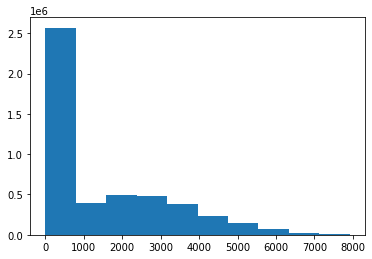

In [353]:
import matplotlib.pyplot as plt
#def obs_freq_calculator(cell_data): #convert back to function once fixed
    #calculate pairwise distances for entire celldata subset
#all_dists =  np.tril(pairwise_distances(cell_data[['x', 'y']].to_numpy(), n_jobs=2))
grouped_cells = test_data.groupby('subclass') #change this to 'subclass' later
subclasses = list(grouped_cells.groups.keys())[0:1]
for i in subclasses:
    for j in subclasses:
        clust_dists = np.tril(pairwise_distances(cell_data[cell_data['subclass']==i][['x', 'y']].to_numpy(), 
                                                 cell_data[cell_data['subclass']==j][['x', 'y']].to_numpy(), 
                                                 n_jobs=2)) #can still be self vs self?
        plt.hist(clust_dists[:].flatten()) #remove zeros

#smart way to save in between info?
# goal is to compare hists for one combo vs same but with random locs. When done: Can be tidied - what are weaknesses here? 

In [ ]:
# calculate one-tailed z-test of observed vs randomized. 
# grabbed formula from online math homework site
# z = (sample mean – population mean) / [population standard deviation/sqrt(n)]
obs_freq_calcs = pd.read_csv('all_grouped_obs_freq_calcs.csv')
real_data = obs_freq_calcs[obs_freq_calcs['count']==-1]
rand_data = obs_freq_calcs[obs_freq_calcs['count']!=-1]
for index, row in real_data.iter_rows():
    sample_counts = row['obs_freq'] #not a mean?
    rand_counts = rand_data[rand_data['root_cell_type']==row['root_cell_type'] & 
                                  rand_data['int_cell_type']==row['int_cell_type']].obs_freq.values.tolist()
    rand_mean = np.mean(population_counts)
    rand_std = np.std(population_counts)
    z_score = (sample_counts - rand_mean) / (rand_std/np.sqrt(sample_counts)) #is this right?
    real_data.iloc[index, 'z-test_score'] = z_score
real_data.to_csv('scored_real_cci.csv')

### test/scratch below

cell-cell interactions arising from somatic contact or paracrine signaling, which can be inferred based on contact or proximity between cells that occurred with higher frequency than by random chance (29, 30). 

We examined whether these potential cell-cell interactions were cell-type specific. To this end, we only considered cell types at the subclass level and determined the frequency with which cell-cell contacts (or proximity) were observed between two subclasses of cells. 

Two neighboring cells were considered contacting (or in proximity) if their centroid distance was <15 μm, which is approximately the size of the soma of a single cell in both human and mouse cortex (31). 

We determined how much this frequency was above random chance and how significant this difference was by comparing the observed contact frequency with the expected contact frequencies from spatial permutations. 

To avoid artifacts arising from the laminar organization of cells and spatial variation of cells density (namely, cell types in the regions of higher cell density or with similar laminar distributions can result in a higher contact frequency by random chance), we designed our spatial permutations to only disrupt the spatial relationship between neighboring cells while still preserving the laminar distribution and local density of each cell type


![image.png](attachment:image.png)
Fig S10: 
(A) Schematic of spatial permutation test that determines the significance of interactions between cell types. Two cells were considered contacting if their nucleus centroids were within 15 μm in the imaging plane, which is approximately the size of the cell body of a single neuron. Contact frequency between any two cell types was determined as the observed frequency. Then, spatial localization of each cell was randomized within a radius of 50 μm, unless otherwise mentioned. Expected contact frequency between any two cell types was determined in each permutation and such permutation was performed 1,000 times to obtain the distribution of expected contact frequencies. The significance of observed contact frequency was calculated using one-tailed z-test and P-values were corrected to FDR (false discovery rate) using Benjamini-Hochberg Procedure. 
(B) Spatial map of L2/3 IT cells in a human MTG slice. (Left) Measured spatial map. (Middle and right) Two example spatial maps after spatial permutations described in (A). 
(C) Cortical depth distributions of L2/3 IT cells (light blue) and other cells (light red) in the human MTG slice shown in (B). (Left) Measured cortical depth distributions. (Middle and right) Cortical depth distributions after two example spatial permutations described in (A).

Summary: 
- For Each Z plane, for each specimen
    - Grab all cells within said plane
    - Find all sets of individual cells that are within 15um of one another (maybe go cell by cell? Is there a faster way?)
    - group by cell type and calculate observed frequency of cell type - cell type interaction
    - randomize spatial location of all cells by 50um and recalculate observed frequency (save two of these)
    - do so 1000 times to get a distribution
    - calculate one-tailed z-test of observed vs randomized. Benjamini-Hochberg goes here?
    - plot spatial map of specific cell types of interest pre randomization and post 2 randomizations (this will probably involve saving two randomizations and creating new h5ad files for them, possibly concatting them together so they can all be cirro doritod)
    - plot histogram of cortical depth distro of celltypes of interest vs all other cells pre and post 2 permutations.

In [335]:
# #TEST CELL TO FIGURE OUT DUPLICATE REMOVAL
# #test_df[test_df.rel.apply(lambda x: np.intersect1d(x, list(test_df.index)).size > 1)] #works but removes EVERYTHING, not just duplicates
# #above would work if we could guarantee multiple list items per index, but we cant
# #"find value from series where series at that value equals original value index... but then only remove the duplicates!"
test_df = pd.DataFrame({'rel' : [[2], [1,3], [4,2], [3]], 'type' : ['a', 'b', 'a', 'c']}, index = [1, 2, 3, 4])
display(test_df)
def remove_dups(rel_list):  #WORKS PERFECTLY!!!!! Can I make it more efficient?
    for val in rel_list:
        for v in val:
            if type(v) == int:
                idx = test_df[test_df.rel.apply((lambda x: v in x))].index.tolist()[0]
                pair_val = test_df.loc[v, 'rel']
                if idx in pair_val:
                    pair_val.remove(idx)
test_df.apply(lambda x: remove_dups(x)) 
test_df

,rel,type
1,[2],a
2,[1],b
3,[4],a
4,[3],c


,rel,type
1,[2],a
2,[],b
3,[4],a
4,[],c
